<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/quantum/grover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install qulacs

In [3]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

## Google Colaboratory / (Linux or Mac)のjupyter notebook 環境の場合にのみ実行してください。
## Qulacsのエラーが正常に出力されるようになります。
!pip3 install wurlitzer
%load_ext wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
## 係数の絶対値の分布をプロットする関数
def show_distribution(state,nqubits):
    plt.bar([i for i in range(pow(2,nqubits))], abs(state.get_vector()))
    plt.show()

[量子状態を初期化](https://dojo.qulacs.org/ja/latest/notebooks/3.1_Qulacs_tutorial.html?highlight=set_computational_basis#%E9%87%8F%E5%AD%90%E7%8A%B6%E6%85%8B%E3%81%AE%E5%88%9D%E6%9C%9F%E5%8C%96)

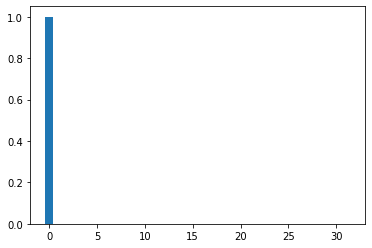

In [14]:
nqubits = 5
state: QuantumState = QuantumState(nqubits)
state.set_zero_state()

show_distribution(state,nqubits)

Hadamard 変換で一様状態に変換

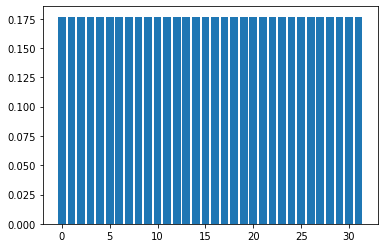

In [15]:
def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state,nqubits)

Oracle を作成 (正答に対する位相反転)。
回答は $|11...1>$。

In [17]:
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    # Z ゲート (z 方向 Pauli 行列) は位相反転演算子
    # & Z ゲートを最後の量子ビットに作用 ((nqubits-1)-th qubit)
    # cf. http://docs.qulacs.org/ja/latest/intro/4.1_python_tutorial.html#id13
    CnZ = to_matrix_gate(Z(nqubits-1))
    # |11...1>　だけ位相反転 (|1> に対する位相反転は常に符号反転)
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        # 対象を i 番目成分が 1 であるベクトルに制限
        # cf. http://docs.qulacs.org/ja/latest/intro/4.1_python_tutorial.html#id12
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

正答に対する位相反転を確認

In [7]:
hoge: QuantumState = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


拡散変換

In [18]:
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    # 2|0><0| - I = diag(1, -1, -1, ...) の実装
    # まず、位相(-1)を全ての状態に付与する。ゲート行列は array([[-1,0],[0,-1]])
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi)))

    # ---------------------- #
    # |00...0> のみ 位相反転 #
    # ---------------------- #

    # X ゲート (x 方向 Pauli 行列) は NOT ゲートとみなせる
    # |00...00> -> |00...01>
    U_s.add_gate( X(nqubits-1) )

    # |00...01> -> -|00...01>
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        # 対象を i 番目成分が 0 のベクトルに制限する
        # cf. http://docs.qulacs.org/ja/latest/intro/4.1_python_tutorial.html#id12
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    # -|00...01> -> -|00...00>
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

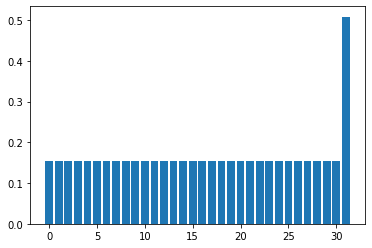

In [9]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

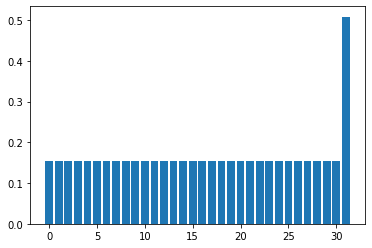

0.5082329989778305


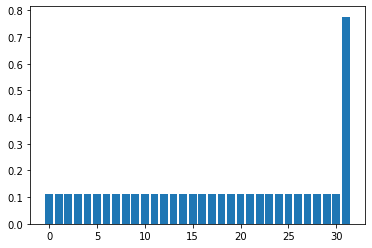

0.7761601777867947


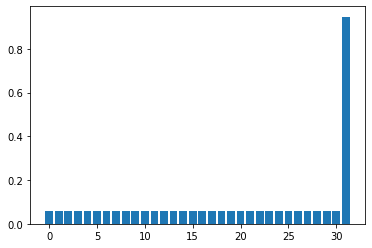

0.9470673343724091


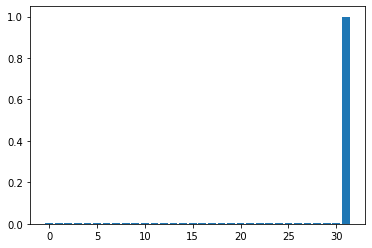

0.9995910741614723


In [10]:
# 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
# 2**n_qubits-1 は 2進数で 1...1
target_state.set_computational_basis(2**nqubits-1)

# グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    print(np.linalg.norm(inner_product(state, target_state)))

maximal probability 9.997306e-01 is obtained at k = 25


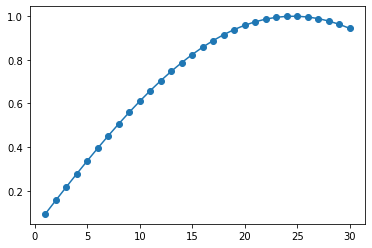

In [11]:
nqubits = 10
state = QuantumState(nqubits)
state.set_zero_state()

## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
Hadamard = make_Hadamard(nqubits)
U_w= make_U_w(nqubits)
U_s = make_U_s(nqubits)

result = []

state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)
for k in range(30):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    #show_distribution(state,nqubits)
    result.append(np.linalg.norm(inner_product(state, target_state)))

max_k = np.argmax(result)
print( f"maximal probability {result[max_k]:5e} is obtained at k = {max_k+1}")

plt.plot(np.arange(1, 30+1), result, "o-")

In [12]:
result = []
min_nqubits = 6
max_nqubits = 16
for nqubits in range(min_nqubits, max_nqubits+1, 2):
    # 回路の準備
    Hadamard = make_Hadamard(nqubits)
    U_w= make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    # 2**n_qubits-1 は 2進数で 1...1
    target_state.set_computational_basis(2**nqubits-1)

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)

    # 確率が減少を始めるまで U_s U_w をかける
    tmp = 0
    flag = 0
    num_iter = 0
    while flag == 0 and num_iter <= 1000:
        num_iter += 1
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        suc_prob = np.linalg.norm(inner_product(state, target_state))
        if tmp < suc_prob:
            tmp = suc_prob
        else:
            flag = 1
    result.append( [nqubits, num_iter, suc_prob] )
    print(f"nqubits={nqubits}, num_iter={num_iter}, suc_prob={suc_prob:5e}")

nqubits=6, num_iter=7, suc_prob=9.526013e-01
nqubits=8, num_iter=13, suc_prob=9.930691e-01
nqubits=10, num_iter=26, suc_prob=9.963280e-01
nqubits=12, num_iter=51, suc_prob=9.992534e-01
nqubits=14, num_iter=101, suc_prob=9.998851e-01
nqubits=16, num_iter=202, suc_prob=9.999368e-01


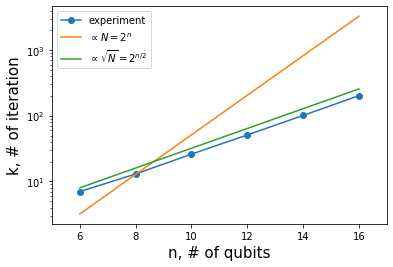

In [13]:
result_array = np.array(result)

plt.xlim(min_nqubits-1, max_nqubits+1)
plt.xlabel("n, # of qubits", fontsize=15)
plt.ylabel("k, # of iteration", fontsize=15)
plt.semilogy(result_array[:,0], result_array[:,1], "o-", label="experiment")
plt.semilogy(result_array[:,0], 0.05*2**result_array[:,0], "-", label=r"$\propto N=2^n$")
plt.semilogy(result_array[:,0], 2**(0.5*result_array[:,0]), "-", label=r"$\propto \sqrt{N}=2^{n/2}$")
plt.legend(fontsize=10)